# Exercise 1 - R: Linear Regression

## **Part One:** Univariate linear regression

Predicting restaurant profits with city population

Beginning with package imports, data loading, and initial visualization

In [1]:
suppressPackageStartupMessages({
  library(readr)
  library(ggplot2)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

Warning message:
"package 'readr' was built under R version 3.3.3"

In [2]:
dfRest <- read_csv("~/Projects/Machine Learning/machine-learning-ex1/ex1/ex1data1.txt",
                   col_names = FALSE,
                   col_types = 'dd')

colnames(dfRest) <- c('Population', 'Profit')

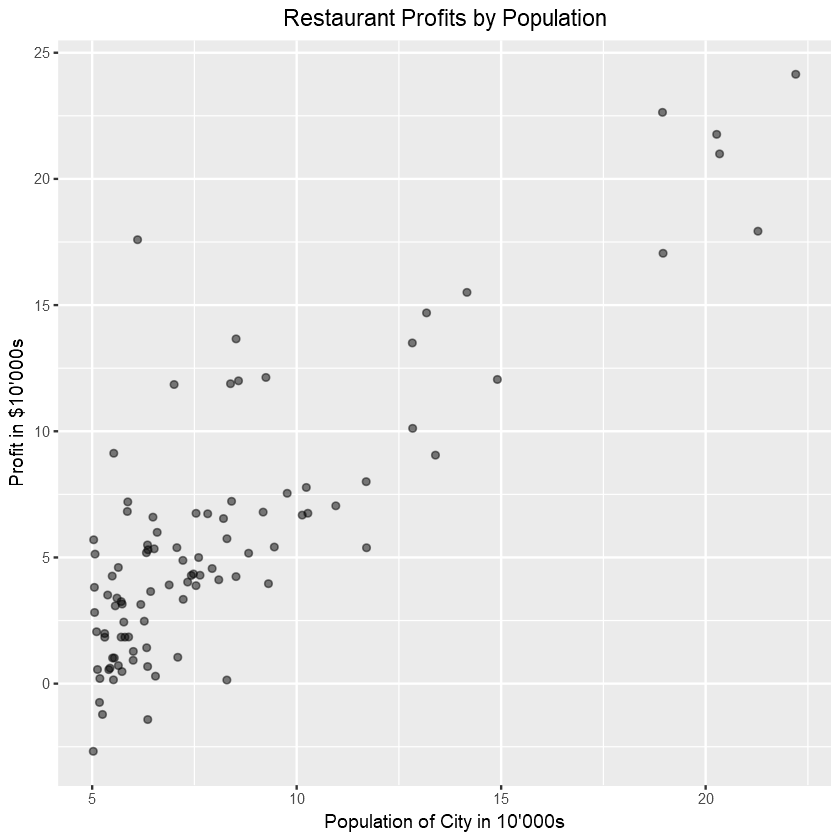

In [3]:
ggplot(dfRest) + 
  geom_point(aes(x=Population, y=Profit), alpha=0.5) +
  xlab("Population of City in 10'000s") +
  ylab("Profit in $10'000s") + 
  ggtitle("Restaurant Profits by Population")

In [4]:
dfRest$Intercept <- 1

X <- dfRest %>% select(Intercept, Population)
y <- dfRest$Profit

### Cost Function

**Hypothesis**: $h_\theta(x) = \theta_0 + \theta_1x_1$

- Notation:

    - $\theta_0$: Intercept

    - $\theta_1$: Coefficient of the regressor.  Statisticians will often write this as $\beta_1$

**Cost Function**: $J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2$

- Notation:

    - $m$: Number of records

    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)

In [5]:
cost_function <- function(X, y, theta){
  # Calculates the squared error
  m <- length(y)
  h <- as.matrix(X) %*% as.matrix(theta)  # Matrix multiplication
  squaredError <- sum((h-y)^2)
  J <- (1/(2*m))*squaredError
  return(J)
}

cost_function(X, y, c(0,0))

[1] 32.07273

Showing the cost function of a few values of $\theta_1$ in a plot

Theta_1 1.5: 25.65889 
Theta_1 1.0: 7.445856 
Theta_1 0.5: 9.583802 


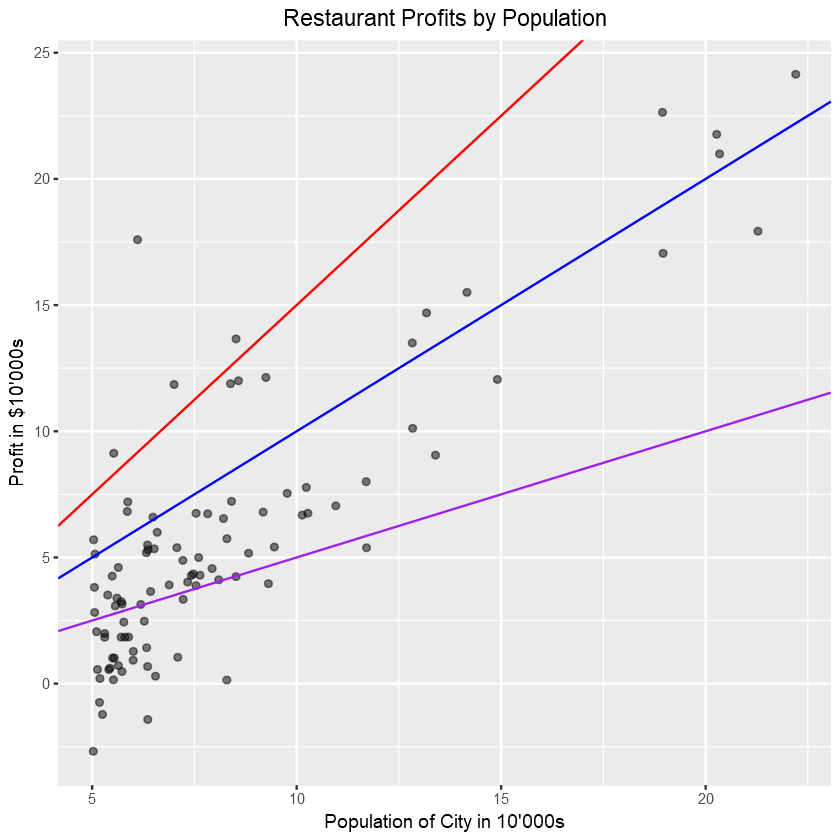

In [6]:
ggplot(dfRest) + 
  geom_point(aes(x=Population, y=Profit), alpha=0.5) +
  geom_abline(slope=1.5, color='red') +
  geom_abline(slope=1.0, color='blue') +
  geom_abline(slope=0.5, color='purple') +
  xlab("Population of City in 10'000s") +
  ylab("Profit in $10'000s") + 
  ggtitle("Restaurant Profits by Population")

cat('Theta_1 1.5:', cost_function(X, y, c(0,1.5)), '\n')
cat('Theta_1 1.0:', cost_function(X, y, c(0,1.0)), '\n')
cat('Theta_1 0.5:', cost_function(X, y, c(0,0.5)), '\n')

### Gradient Descent

Repeat until convergence:

$\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})$

$\theta_1 := \theta_1 - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)}) \cdot x^{(i)}$

- Notation:

    - $\theta_0$: Intercept

    - $\theta_1$: Coefficient of the regressor.  Statisticians will write this as $\beta_1$

    - $m$: Number of records

    - $i$: Index of the record (e.x. if $i = 46$, then 46th row)
    
    - $\alpha$: Learning rate (e.g. size of step for gradient descent to take at each iteration)
    
Alternatively, assume the $x_0 = 1$, to use the more convenient expression:

$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)}) \cdot x_j^{(i)}$

In [7]:
gradient_descent <- function(X, y, alpha, iterations) {
  # Batch gradient descent
  # Calculates and stores the cost at each iteration for plotting
  costIteration <- numeric(length(y))  # For storing the cost function at each iteration
  theta <- numeric(length(X))  # Initializing thetas with 0s
  m <- length(y)
  
  # Loops are inefficient in R, so there may be better ways to do this
  for (i in 1:iterations) {
    h <- as.matrix(X) %*% as.matrix(theta)
    hError <- h-y
    theta <- theta - alpha*(1/m)*(t(as.matrix(X)) %*% as.matrix(hError))
    
    costIteration[i] <- cost_function(X, y, theta)
  }
  return(list("Theta" = theta, "costHistory" = costIteration))
}

alpha <- 0.01
iterations <- 1500

pt1GradientDescent <- gradient_descent(X, y, alpha, iterations)
pt1GradientDescent$Theta

Intercept,-3.630291
Population,1.166362


In [8]:
# Comparing to R's native linear regression
pt1_lm <- summary(lm(Profit ~ Population, data=dfRest))$coefficients
pt1_lm

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-3.895781,0.71948282,-5.414696,4.607887e-07
Population,1.193034,0.07974394,14.960806,1.023210e-26


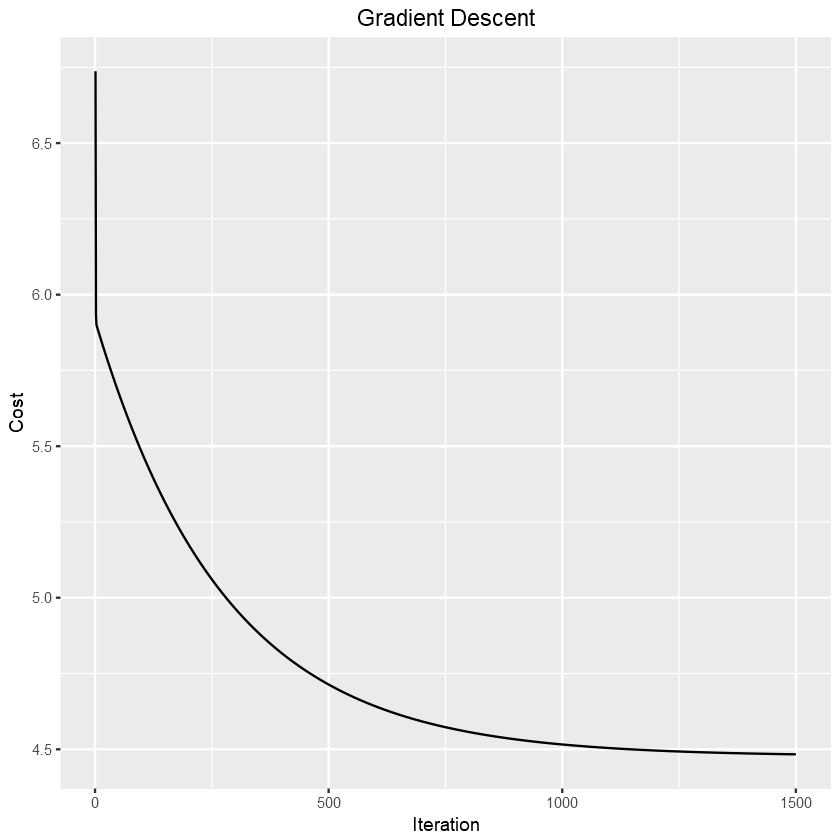

In [9]:
data.frame(Iteration=1:length(pt1GradientDescent$costHistory),
           Cost=pt1GradientDescent$costHistory) %>% 
  ggplot() + 
    geom_line(aes(y=Cost, x=Iteration)) +
    ggtitle('Gradient Descent')

Displaying predictions on top of the data

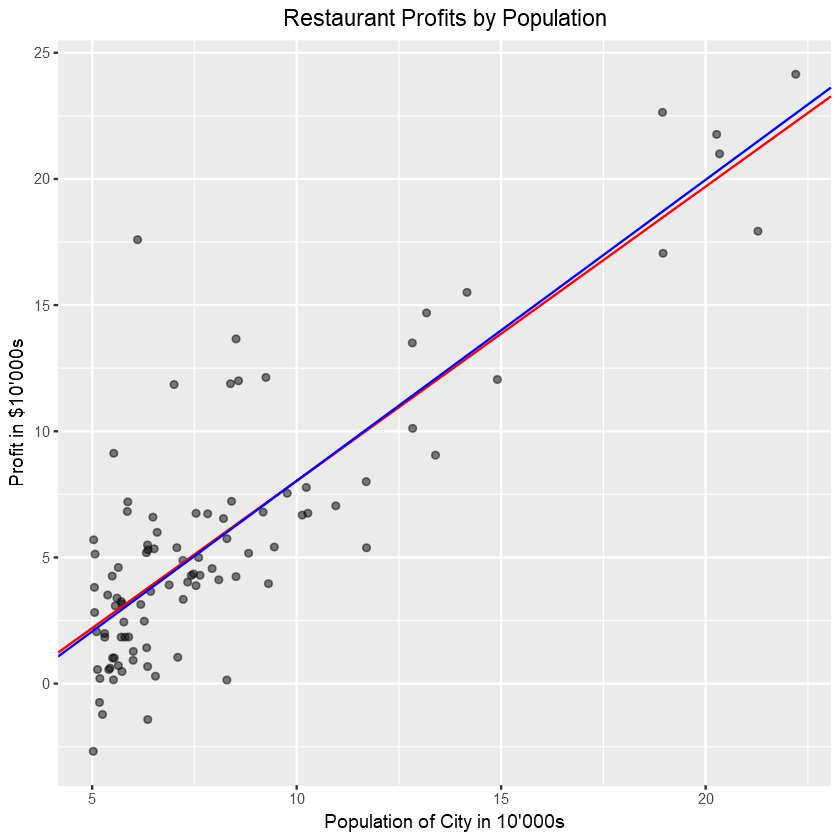

In [10]:
ggplot(dfRest) + 
  geom_point(aes(x=Population, y=Profit), alpha=0.5) +
  geom_abline(intercept=pt1GradientDescent$Theta[1],
              slope=pt1GradientDescent$Theta[2], color='red') +
  geom_abline(intercept=pt1_lm[1],
              slope=pt1_lm[2], color='blue') +
  xlab("Population of City in 10'000s") +
  ylab("Profit in $10'000s") + 
  ggtitle("Restaurant Profits by Population")

### Normal Equation

The normal equation is another way to find the optimal values for $\theta$.  Unlike gradient descent, it does not take multiple iterations, but it does not handle large data sets due to being $O(n^3)$.

The equation is $\theta = (X^T X)^{-1}X^Ty$

- Notation:

    - $\theta$: Coefficient of the regressor
    
    - $X$: Regressors in a long format
    
        - E.x. $x^{(i)} = \begin{bmatrix} x_1^{(i)} \\ x_2^{(i)} \\ \vdots \\ x_n^{(i)} \end{bmatrix}$
        
            - $i$: Index of the record (e.x. if $i = 46$, then 46th row)
            
            - $n$: Number of features
            
    - $X^T$: Transposed regressors (in a wide format)
    
        - E.x. $x^{(i)} = \begin{bmatrix} x_1^{(i)}, x_2^{(i)}, \dots, x_n^{(i)} \end{bmatrix}$
        
            - $i$: Index of the record (e.x. if $i = 46$, then 46th row)
            
            - $n$: Number of features
            
    - $y$: Target variable
    
        - E.x. $y = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_m \end{bmatrix}$
        
            - $m$: Number of records

In [11]:
normal_equation <- function(X, y){
  # Returns the optimal values of theta
  X <- as.matrix(X)
  y <- as.matrix(y)
  
  inverseX <- solve(t(X) %*% X)
  return(inverseX %*% t(X) %*% y)
}

pt1normalEquation <- normal_equation(X, y)
pt1normalEquation

Intercept,-3.895781
Population,1.193034


Comparing the parameters of all three methods


In [12]:
pt1results <- data.frame(pt1normalEquation, pt1_lm[1:2], pt1GradientDescent$Theta)
colnames(pt1results) <- c('NormalEquation', 'LinearModel', 'GradientDescent')

pt1results

,NormalEquation,LinearModel,GradientDescent
Intercept,-3.895781,-3.895781,-3.630291
Population,1.193034,1.193034,1.166362


---

##  **Part 2:** Multivariate linear regression

Predicting housing prices with multiple variables

In [13]:
dfHouse <- read_csv("~/Projects/Machine Learning/machine-learning-ex1/ex1/ex1data2.txt",
               col_names = FALSE,
               col_types = 'ddd')

colnames(dfHouse) <- c('Size', 'Bedrooms', 'Price')

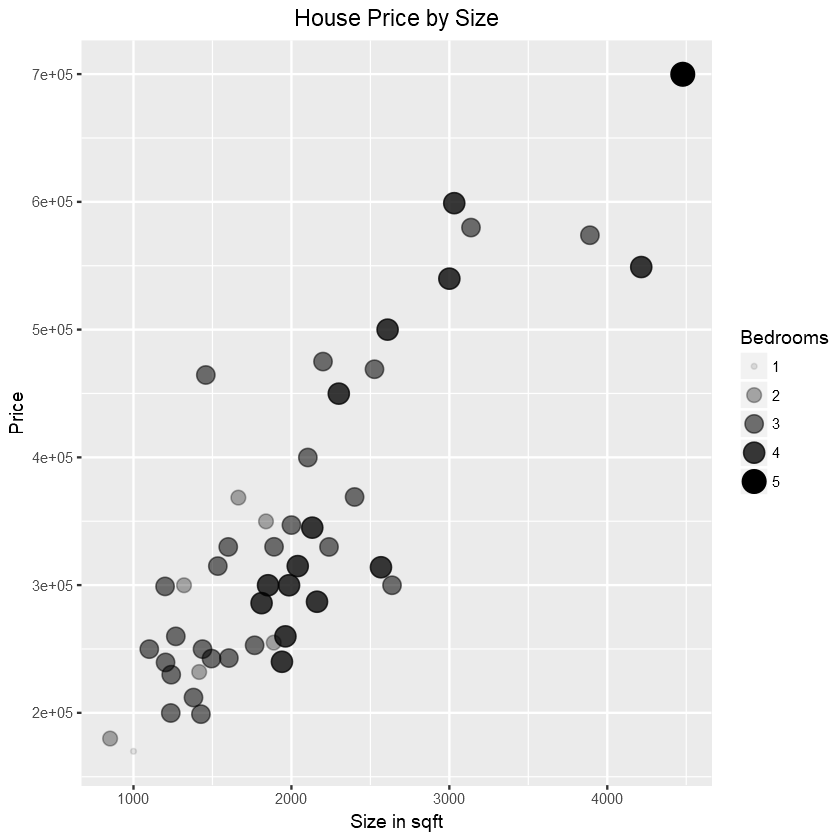

In [14]:
ggplot(dfHouse) +
  geom_point(aes(x=Size, y=Price,
                 alpha=Bedrooms, size=Bedrooms)) +
  xlab('Size in sqft') + 
  ggtitle("House Price by Size")

#### Feature normalization

Normalizing the features with standardization due to house size being significantly larger than the number of bedrooms.  This will play nicer with our gradient descent function.

Standardization: $x' = \frac{x - \bar{x}}{\sigma}$

In [15]:
standard_scaler <- function(x) {
  return ((x - mean(x)) / sd(x))
}

dfHouse_scaled <- as.data.frame(sapply(dfHouse, standard_scaler))

# Adding a column of 1s to better handle theta_0
dfHouse_scaled$Intercept <- 1

X <- dfHouse_scaled %>% select(-Price)
y <- dfHouse_scaled$Price

cost_function(X, y, c(0, 0, 0))

[1] 0.4893617

In [16]:
pt2GradientDescent <- gradient_descent(X, y, alpha, iterations)
pt2GradientDescent$Theta

Size,8.840423e-01
Bedrooms,-5.245518e-02
Intercept,-1.090735e-16


Comparing the parameters of all three methods

In [17]:
pt2_lm <- summary(lm(Price ~ Size + Bedrooms, data=dfHouse_scaled))$coefficient

pt2normalEquation <- normal_equation(X, y)

pt2results <- data.frame(c(pt2_lm[2:3], pt2_lm[1]), pt2normalEquation, pt2GradientDescent$Theta)
colnames(pt2results) <- c('LinearModel', 'NormalEquation', 'GradientDescent')

pt2results

,LinearModel,NormalEquation,GradientDescent
Size,8.847660e-01,8.847660e-01,8.840423e-01
Bedrooms,-5.317882e-02,-5.317882e-02,-5.245518e-02
Intercept,-1.242180e-16,-9.367507e-17,-1.090735e-16


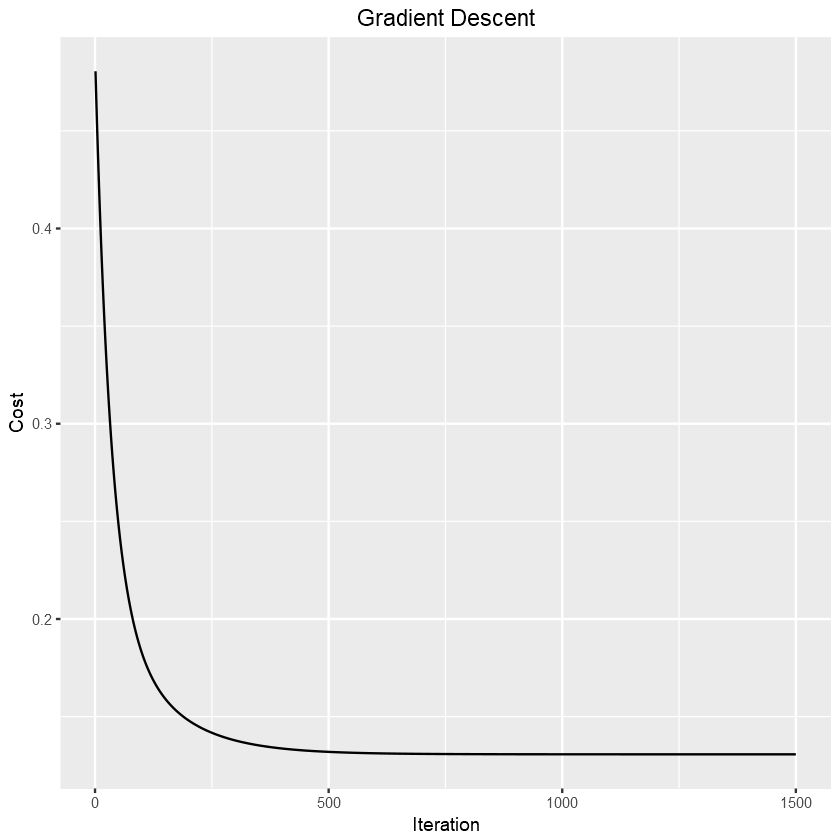

In [18]:
data.frame(Iteration=1:length(pt2GradientDescent$costHistory),
           Cost=pt2GradientDescent$costHistory) %>% 
  ggplot() + 
    geom_line(aes(y=Cost, x=Iteration)) +
    ggtitle('Gradient Descent')

Displaying predictions on top of the data

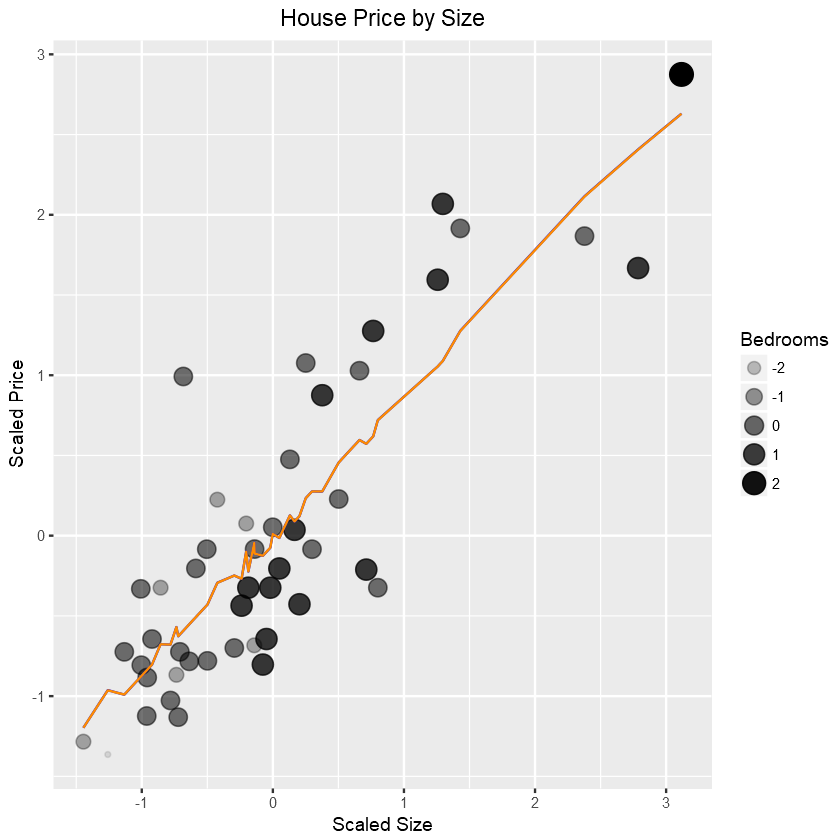

In [19]:
dfHouse_scaled$Prediction <- pt2GradientDescent$Theta[3] +
                               dfHouse_scaled$Size*pt2GradientDescent$Theta[1] +
                               dfHouse_scaled$Bedrooms*pt2GradientDescent$Theta[2]

dfHouse_scaled$nativePrediction <- pt2_lm[1] + 
                                    dfHouse_scaled$Size*pt2_lm[2] +
                                    dfHouse_scaled$Bedrooms*pt2_lm[3]

ggplot(dfHouse_scaled) +
  geom_point(aes(x=Size, y=Price,
                 alpha=Bedrooms, size=Bedrooms)) +
  geom_line(aes(x=Size, y=nativePrediction), color='blue') +
  geom_line(aes(x=Size, y=Prediction), color='darkorange') +
  xlab('Scaled Size') +
  ylab('Scaled Price') +
  ggtitle("House Price by Size")

Choosing $\alpha$

In [20]:
timeStart <- proc.time()

pt2GradientDescent001 = gradient_descent(X, y, alpha=0.001, iterations=iterations)
pt2GradientDescent01 = gradient_descent(X, y, alpha=0.01, iterations=iterations)
pt2GradientDescent1 = gradient_descent(X, y, alpha=0.1, iterations=iterations)
pt2GradientDescent10 = gradient_descent(X, y, alpha=1.0, iterations=iterations)

timeStop <- proc.time()

timeStop - timeStart

   user  system elapsed 
   2.00    0.03    2.35 

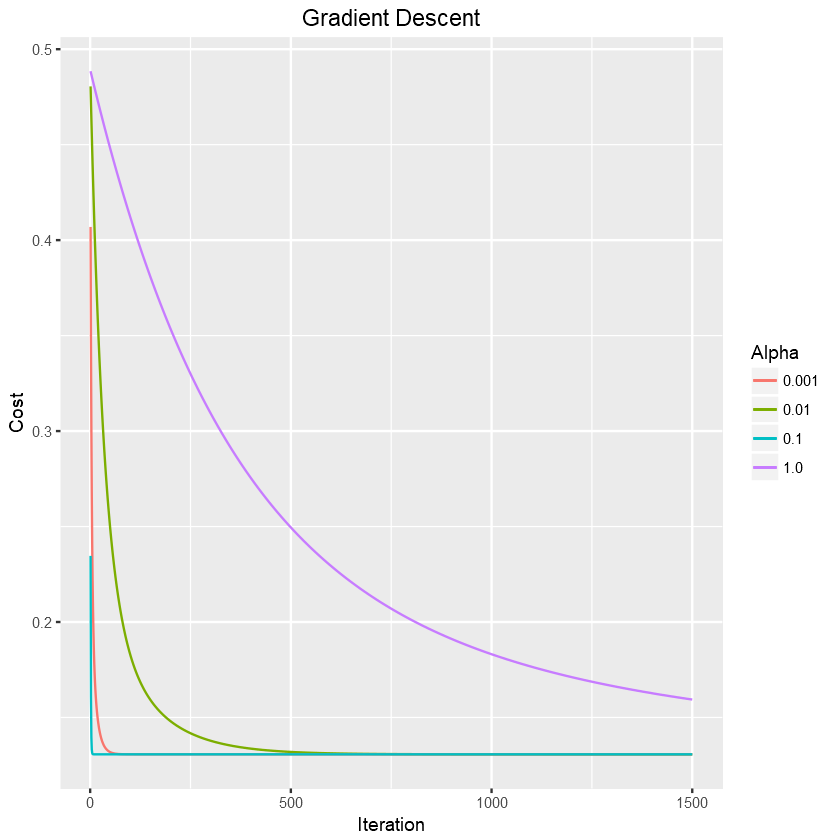

In [21]:
data.frame(Iteration=1:length(pt2GradientDescent001$costHistory),
           Cost=pt2GradientDescent001$costHistory) %>% 
  ggplot() + 
    geom_line(aes(y=Cost, x=Iteration,
              colour="red")) +
    geom_line(aes(y=pt2GradientDescent01$costHistory, x=Iteration,
              colour="green")) +
    geom_line(aes(y=pt2GradientDescent1$costHistory, x=Iteration,
              color="blue")) +
    geom_line(aes(y=pt2GradientDescent10$costHistory, x=Iteration,
              color="purple")) +
    scale_color_discrete(name = "Alpha",
                         labels = c("0.001", "0.01", "0.1", "1.0")) +
    ggtitle('Gradient Descent')